In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install SimpleITK
import SimpleITK as sitk
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [ ]:
def make_mask(center, diam, z, width, height, spacing, origin):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    # convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5])
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin, v_xmax+1)
    v_yrange = range(v_ymin, v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x, p_y, z])) <= diam:
                mask[int((p_y-origin[1])/spacing[1]), int((p_x-origin[0])/spacing[0])] = 1.0
    return mask

In [ ]:
# luna_path = "subset0/"
path = "/content/drive/MyDrive/Lung_Nodule_Analysis/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd"

df_node = pd.read_csv("/content/drive/MyDrive/Lung_Nodule_Analysis/annotations.csv")
name = "1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565"

df_filtered = df_node[df_node['seriesuid'] == name]

print(df_filtered)

                                            seriesuid      coordX      coordY  \
86  1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...  145.967465 -161.197634   

        coordZ  diameter_mm  
86 -312.071347     6.378436  


In [1]:
itk_img = sitk.ReadImage(path, sitk.sitkFloat32)
img_array = sitk.GetArrayFromImage(itk_img)  # indexes are z,y,x (notice the ordering)
num_z, height, width = img_array.shape        # heightXwidth constitute the transverse plane
origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)

NameError: name 'sitk' is not defined

In [ ]:
print(f"slices: {num_z}, heigh: {height} and width: {width}")
print(f"origin : \n{origin}")
print(f"spacing : \n{spacing}")

slices: 195, heigh: 512 and width: 512
origin : 
[-184.63867188 -326.63867188 -385.2       ]
spacing : 
[0.72265625 0.72265625 1.79999995]


In [ ]:
for node_idx, cur_row in df_filtered.iterrows():
    node_x = cur_row["coordX"]
    node_y = cur_row["coordY"]
    node_z = cur_row["coordZ"]
    diam = cur_row["diameter_mm"]
    # just keep 3 slices
    imgs = np.ndarray([3, height, width], dtype=np.float32)
    masks = np.ndarray([3, height, width], dtype=np.uint8)
    center = np.array([node_x, node_y, node_z]) # nodule center
    v_center = np.rint((center-origin)/spacing) # nodule center in voxel space (still x,y,z ordering)
    for i, i_z in enumerate(np.arange(int(v_center[2])-1,
                        int(v_center[2])+2).clip(0, num_z-1)): # clip prevents going out of bounds in Z
        mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                            width, height, spacing, origin)
        masks[i] = mask
        imgs[i] = img_array[i_z]

(<matplotlib.image.AxesImage at 0x7e6860745990>, (-0.5, 511.5, 511.5, -0.5))

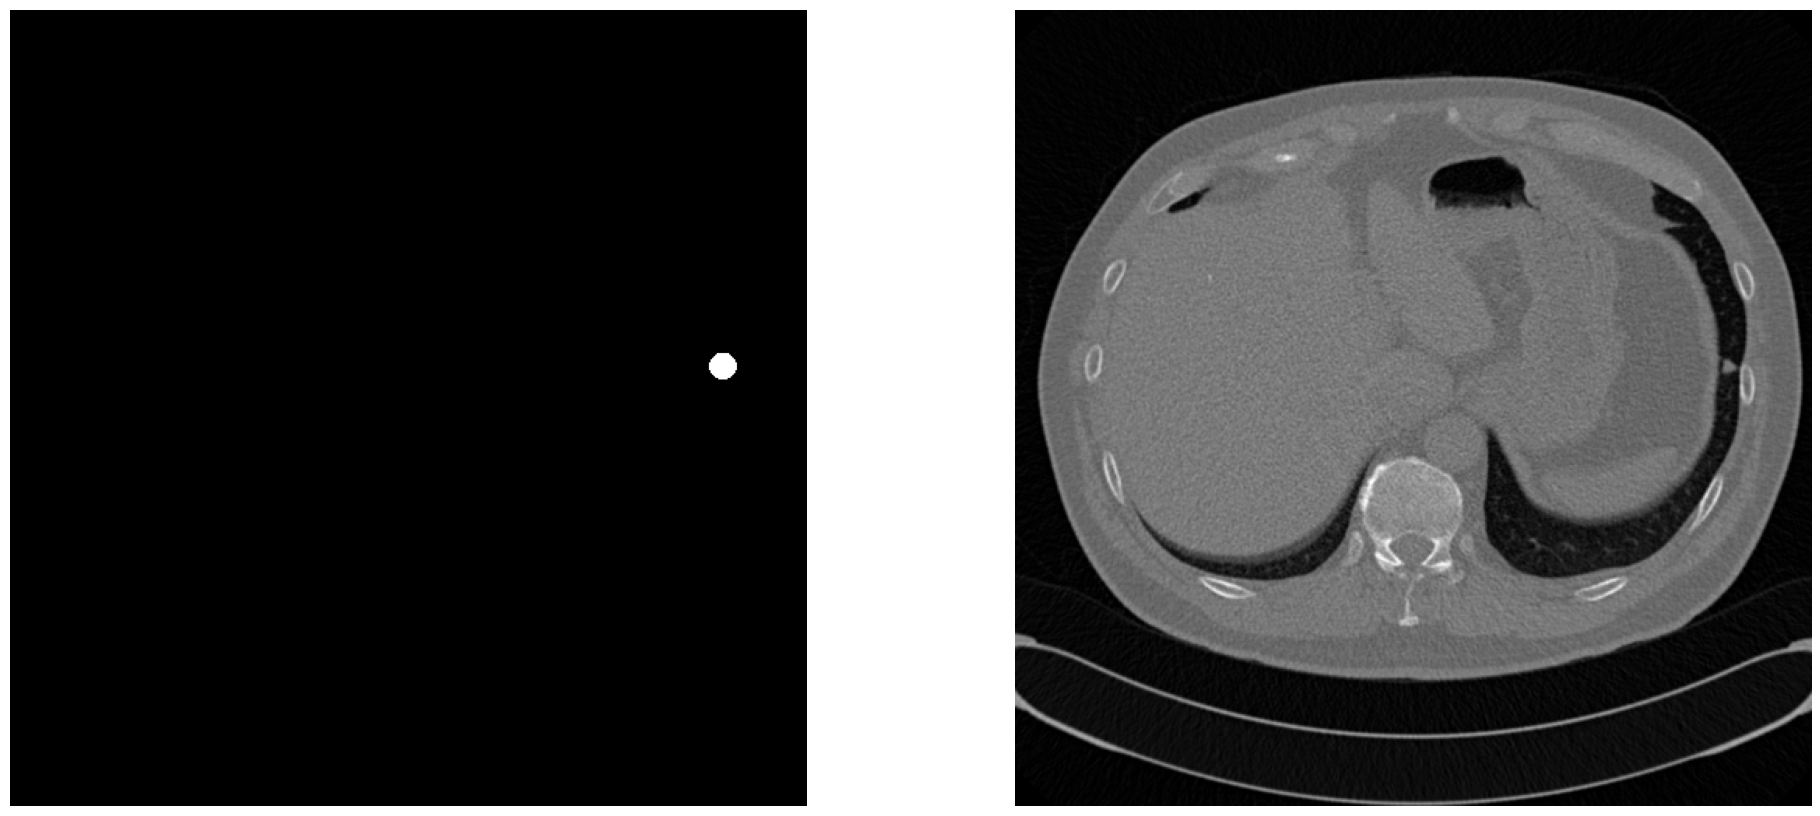

In [ ]:
plt.figure(figsize=(20,16))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.01)
plt.subplot(2,2,1)
plt.imshow(masks[1,:,:]), plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(imgs[1,:,:]), plt.axis('off')

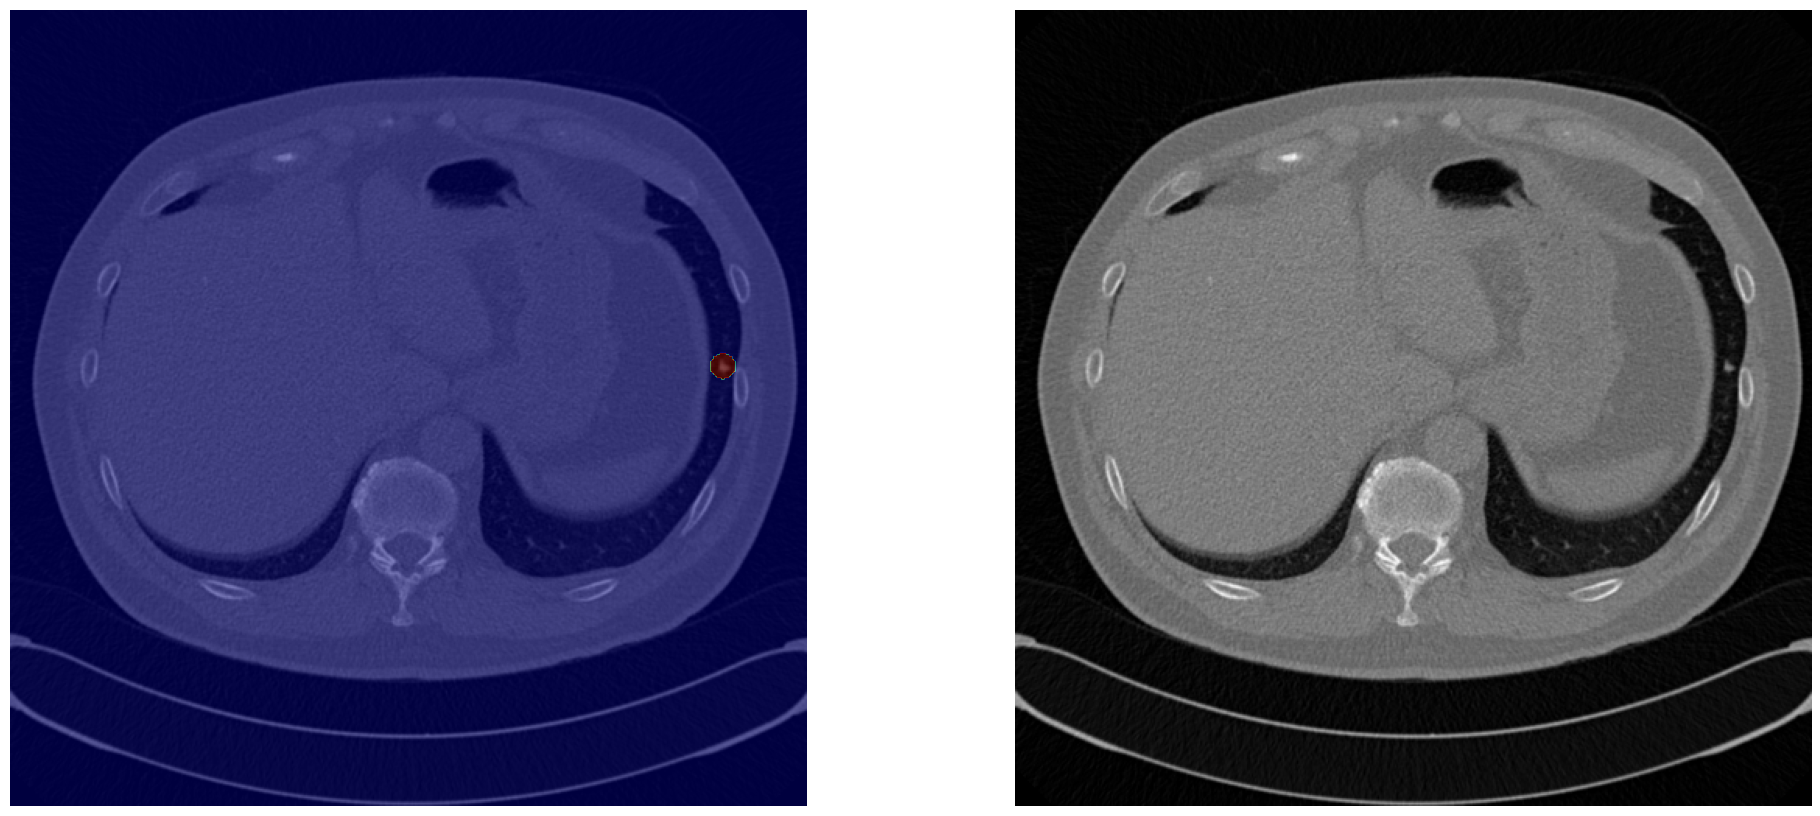

In [ ]:
plt.figure(figsize=(20, 16))
plt.gray()
plt.subplots_adjust(0, 0, 1, 1, 0.01, 0.01)

plt.subplot(2, 2, 1)
plt.imshow(imgs[2, :, :], cmap='gray')
plt.imshow(masks[2, :, :], cmap='jet', alpha=0.5)
plt.axis('off')


plt.subplot(2, 2, 2)
plt.imshow(imgs[2, :, :], cmap='gray')
plt.axis('off')

plt.show()


(<matplotlib.image.AxesImage at 0x7e6847114070>, (-0.5, 511.5, 511.5, -0.5))

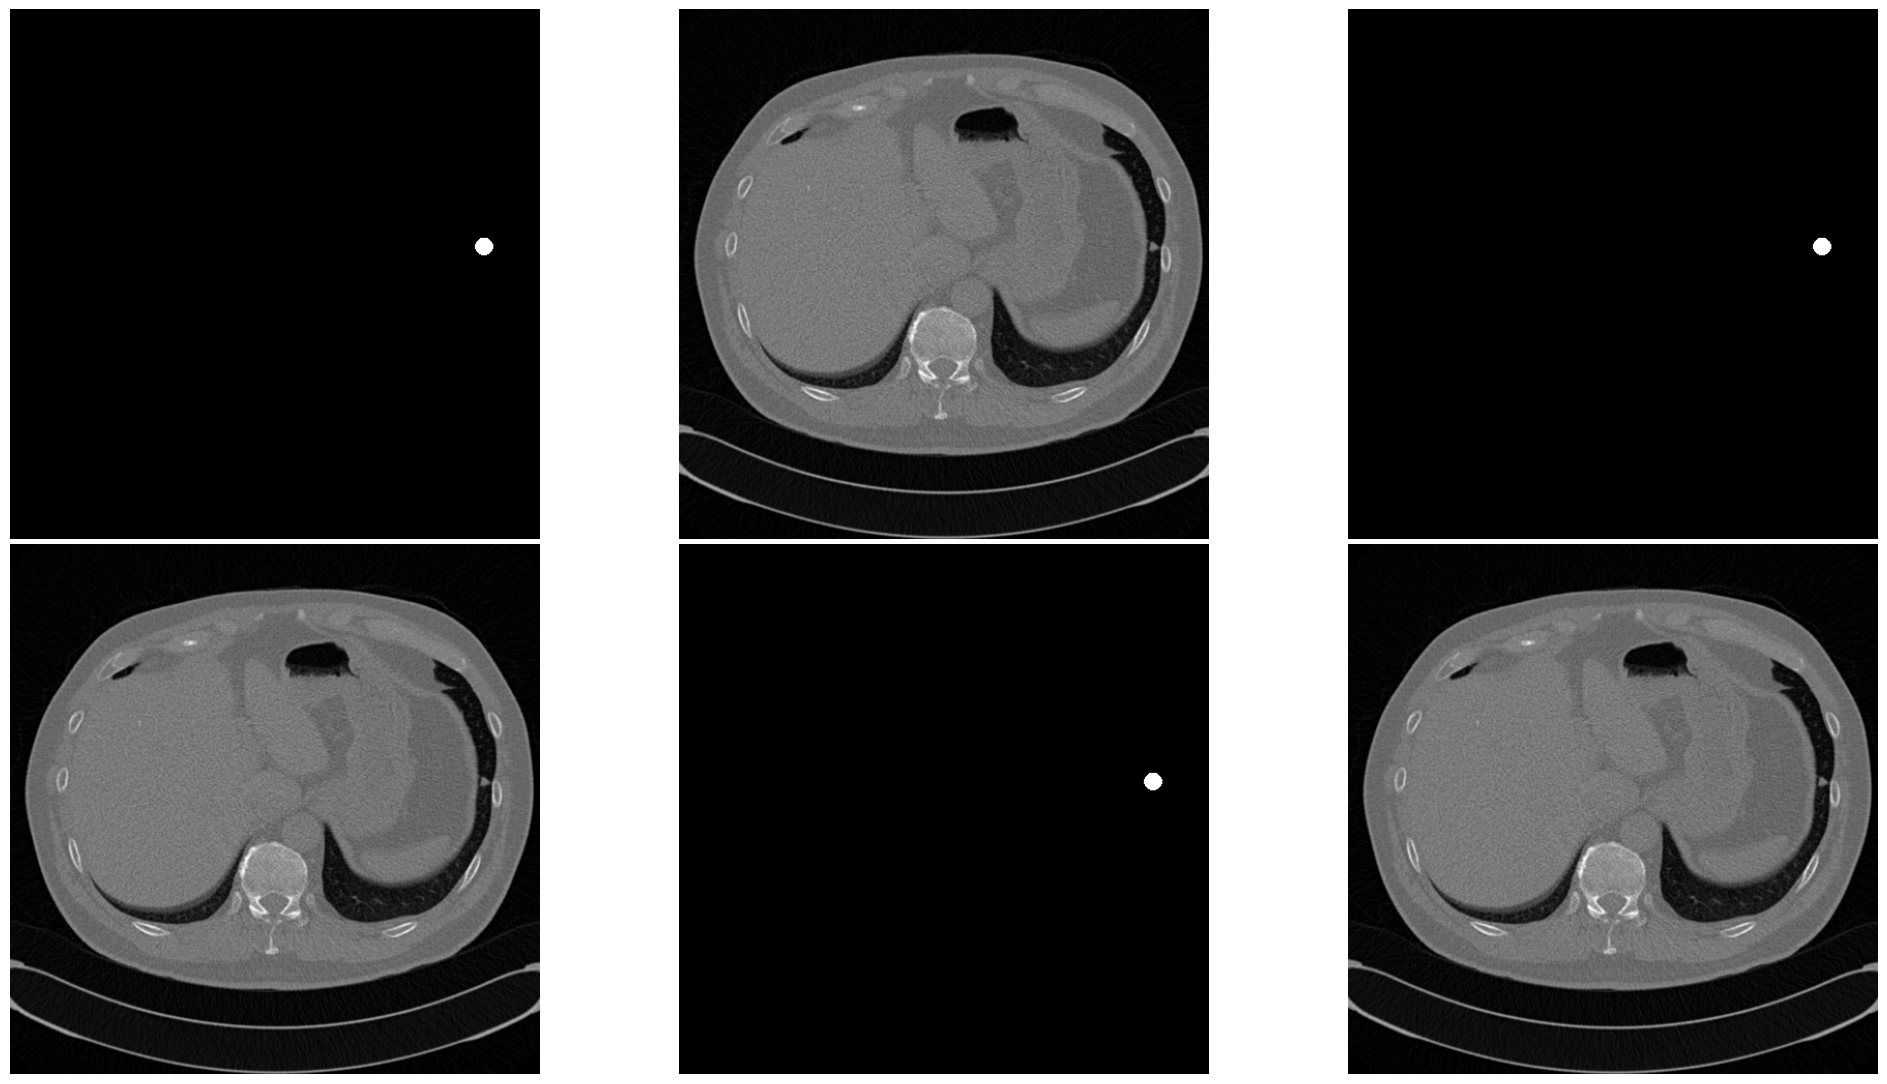

In [ ]:
plt.figure(figsize=(20,16))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.01)
plt.subplot(3,3,1)
plt.imshow(masks[1,:,:]), plt.axis('off')
plt.subplot(3,3,2)
plt.imshow(imgs[1,:,:]), plt.axis('off')
plt.subplot(3,3,3)
plt.imshow(masks[1,:,:]), plt.axis('off')
plt.subplot(3,3,4)
plt.imshow(imgs[1,:,:]), plt.axis('off')
plt.subplot(3,3,5)
plt.imshow(masks[1,:,:]), plt.axis('off')
plt.subplot(3,3,6)
plt.imshow(imgs[1,:,:]), plt.axis('off')

# Tri Planar Slicing

In [ ]:
import numpy as np
import SimpleITK as sitk

def load_itk(filename):
    itkimage = sitk.ReadImage(filename)
    image = np.transpose(sitk.GetArrayFromImage(itkimage))
    origin = np.array(itkimage.GetOrigin())
    spacing = np.array(itkimage.GetSpacing())
    return image, origin, spacing

def world_2_voxel(world_coord, origin, spacing):
    stretched_voxel_coord = np.absolute(world_coord - origin)
    voxel_coord = stretched_voxel_coord / spacing
    return voxel_coord

def voxel_2_world(voxel_coord, origin, spacing):
    stretched_voxel_coord = voxel_coord * spacing
    world_coord = stretched_voxel_coord + origin
    return world_coord

if __name__ == "__main__":
    image, origin, spacing = load_itk(path)
    print('Shape:', image.shape)
    print('Origin:', origin)
    print('Spacing:', spacing)


Shape: (512, 512, 195)
Origin: [-184.63867188 -326.63867188 -385.2       ]
Spacing: [0.72265625 0.72265625 1.79999995]


I have chosen the voxel coordinates for slicing as the center of the image dimensions.

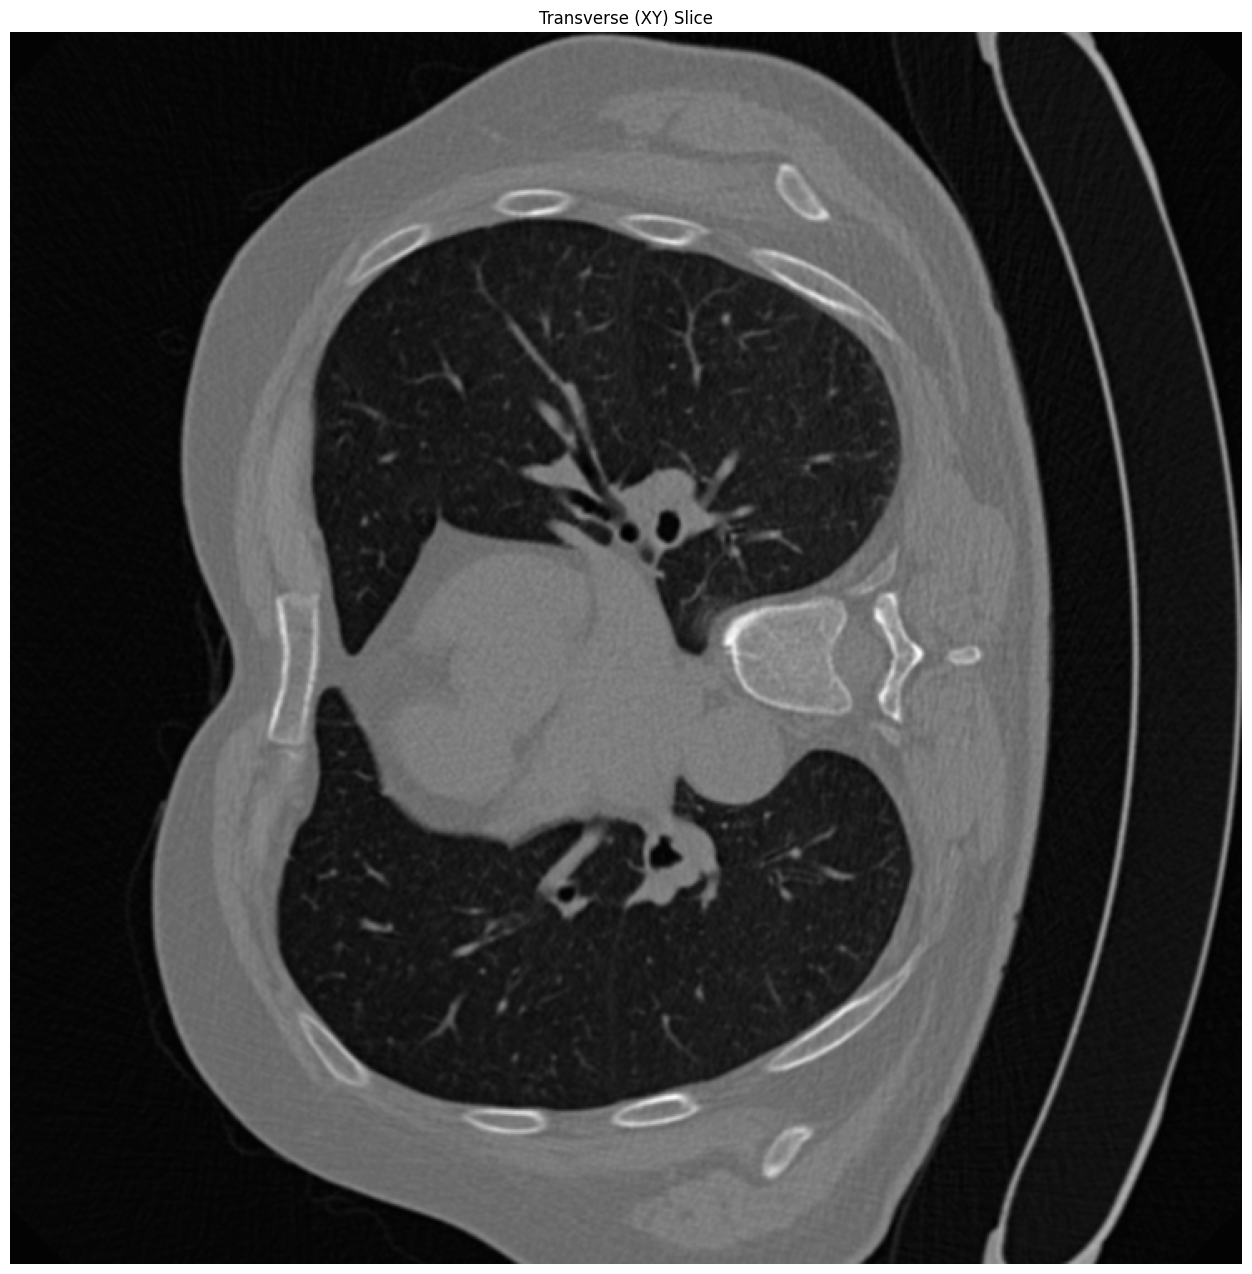

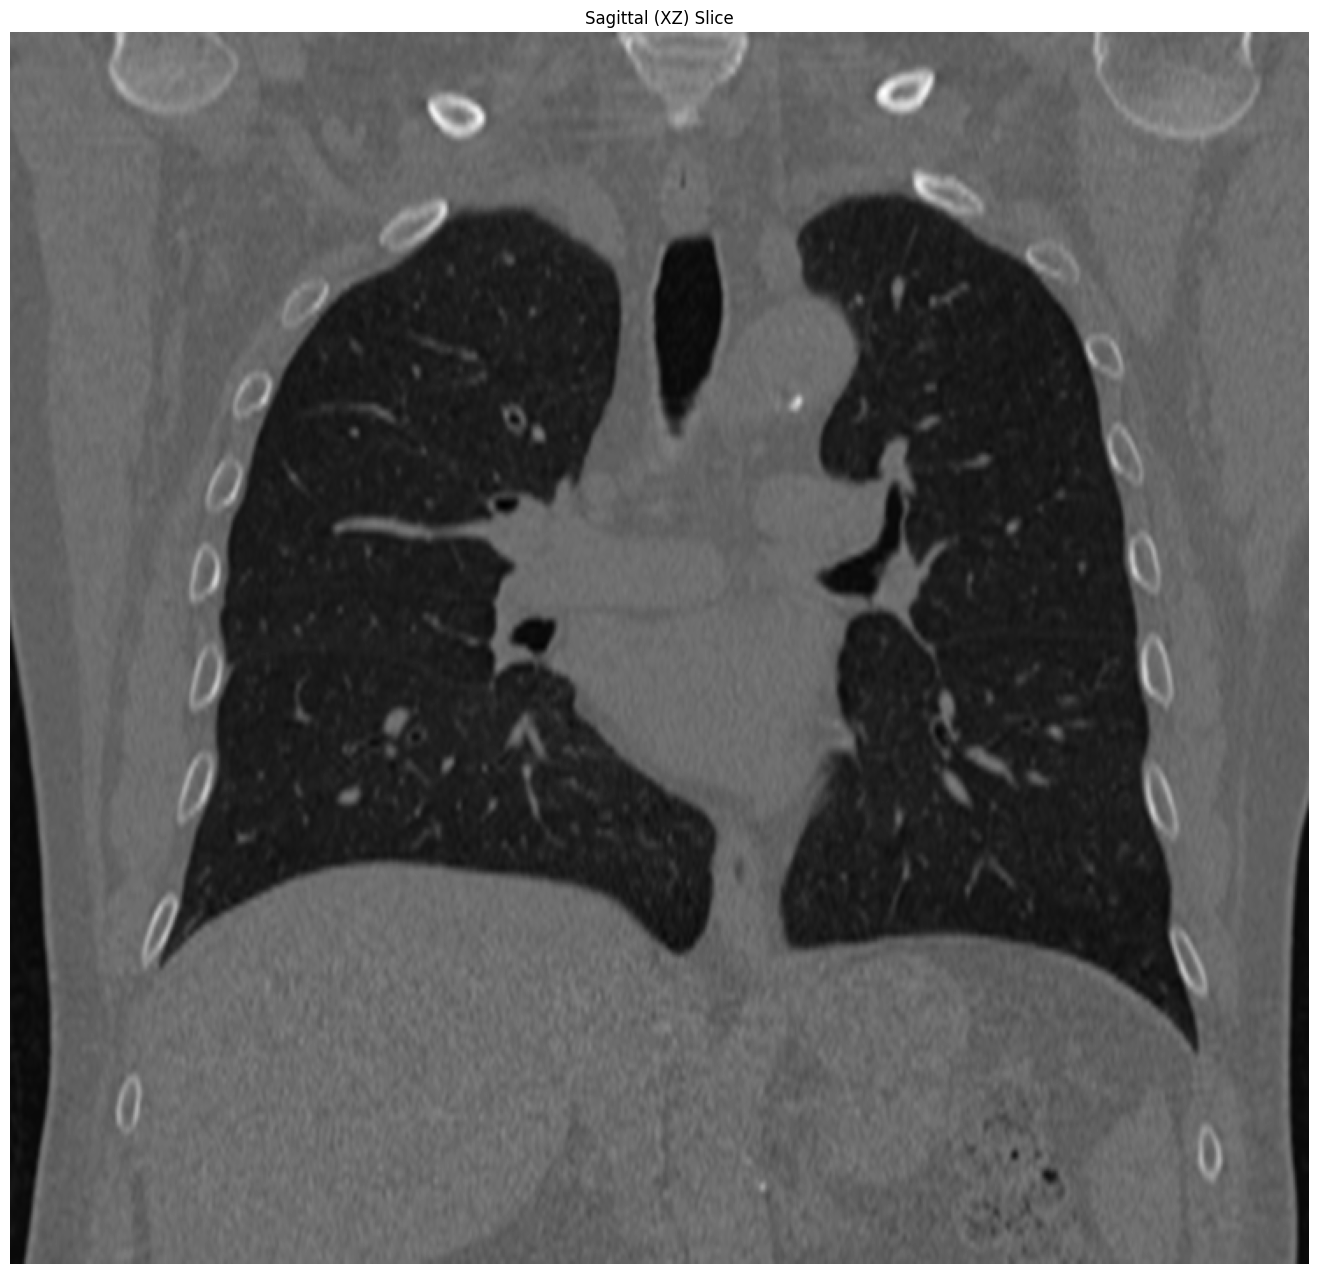

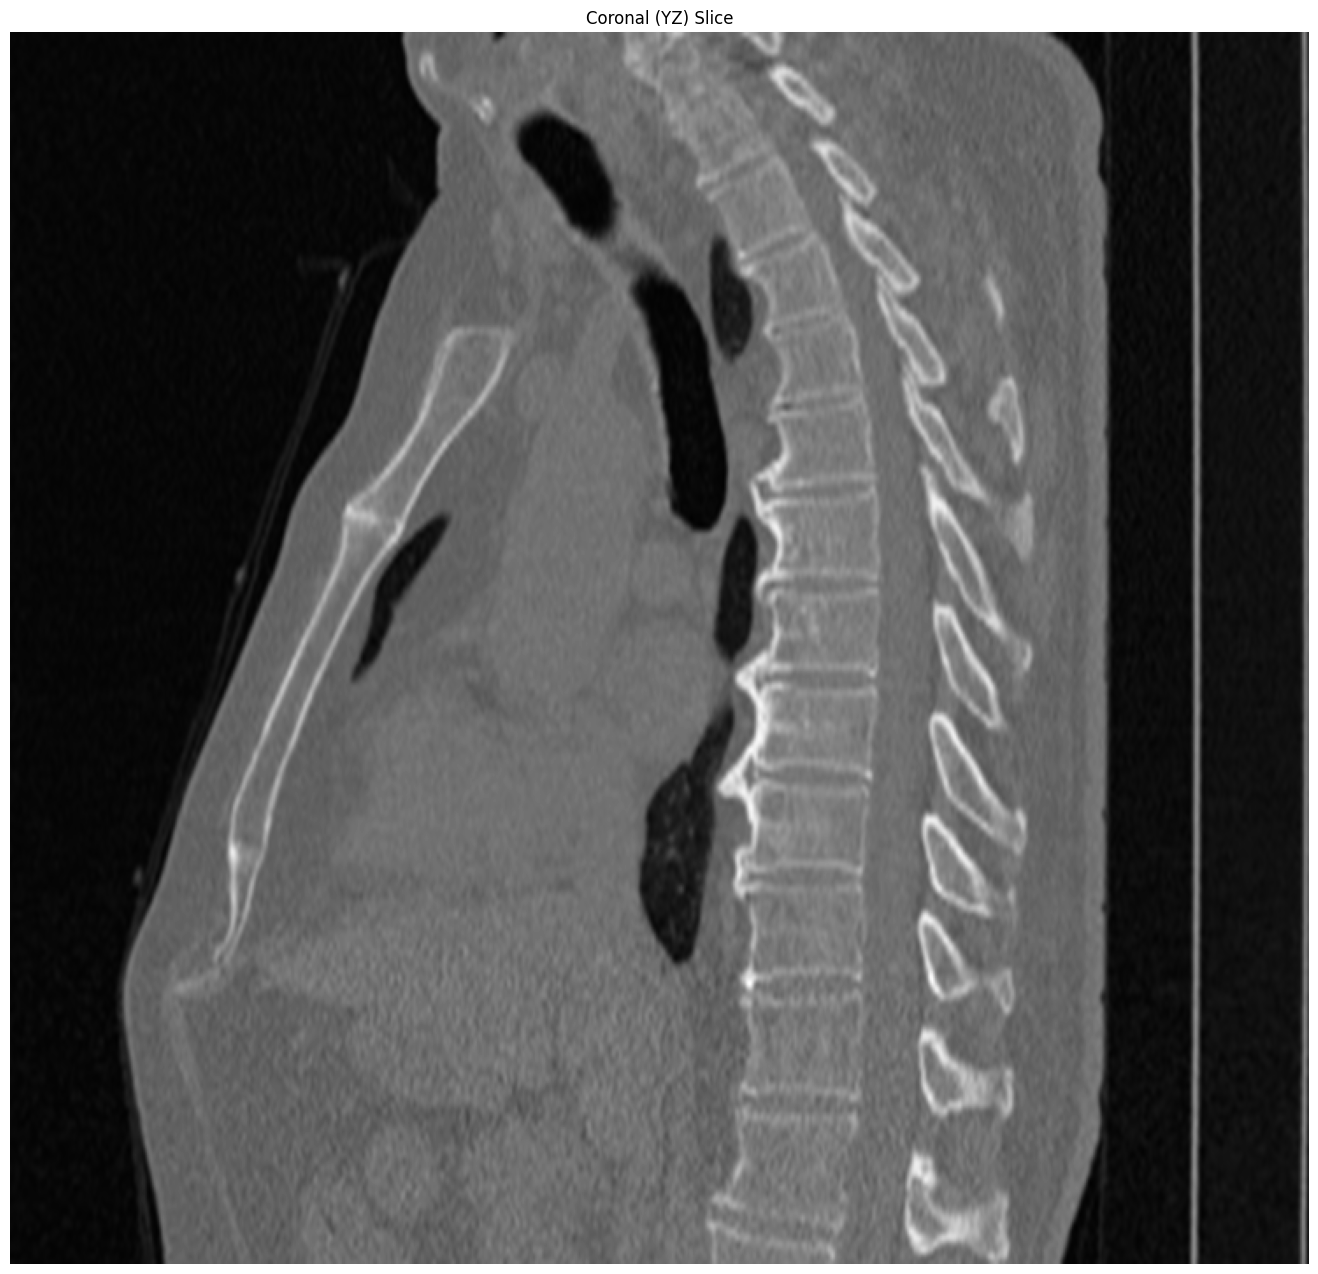

In [ ]:
center_voxel_coord = np.array([image.shape[0]//2, image.shape[1]//2, image.shape[2]//2])


# Transverse slice (XY plane)
xy_slice = image[:, :, center_voxel_coord[2]]

# Sagittal slice (XZ plane)
xz_slice = image[:, center_voxel_coord[1], :]

# Coronal slice (YZ plane)
yz_slice = image[center_voxel_coord[0], :, :]

plt.figure(figsize=(20, 16))
plt.imshow(xy_slice, cmap='gray')
plt.title('Transverse (XY) Slice')
plt.axis('off')
plt.show()

# Display the XZ slice in a separate window
plt.figure(figsize=(20, 16))
plt.imshow(np.rot90(xz_slice), cmap='gray')
plt.title('Sagittal (XZ) Slice')
plt.axis('off')
plt.show()

# Display the YZ slice in a separate window
plt.figure(figsize=(20, 16))
plt.imshow(np.rot90(yz_slice), cmap='gray')
plt.title('Coronal (YZ) Slice')
plt.axis('off')
plt.show()

Refactoring the variable slice thickness in each image into a standardized format of 0.5mm axial , 0.5mm saggital and 0.5mm coronal according to the paper : https://www.slicer.org/wiki/Coordinate_systems#Image_coordinate_system

A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)!

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance.

Whilst this may seem like a very simple step, it has quite some edge cases due to rounding. Also, it takes quite a while. Source : https://www.kaggle.com/code/gzuidhof/full-preprocessing-tutorial

In [ ]:
import scipy.ndimage


OUTPUT_SPACING = [0.5, 0.5, 0.5]

OUTPUT_DIM = 64

image, origin, spacing = load_itk(path)

#calculate resize factor
resize_factor = spacing / OUTPUT_SPACING
new_real_shape = image.shape * resize_factor
new_shape = np.round(new_real_shape)
real_resize = new_shape / image.shape
new_spacing = spacing / real_resize

#resize image
image = scipy.ndimage.interpolation.zoom(image, real_resize)



<ipython-input-49-440f2934bc61>:18: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, real_resize)


In [ ]:
print("Shape after refactoring : " , image.shape)

Shape after refactoring :  (740, 740, 702)


### 1. Loading Data
```python
annotations = pd.read_csv('/content/drive/MyDrive/Lung_Nodule_Analysis/annotations.csv')
```
- This line loads a CSV file containing annotations for lung nodules. The data likely includes coordinates for the nodule locations within the 3D images (series) and possibly additional metadata such as the series UID (unique identifier for each scan) and labels for the type or characteristics of each nodule.

### 2. Identifying Specific Annotations
```python
name = "1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565"
indices = annotations[annotations['seriesuid'] == name].index
print(indices)
```
- These lines define a specific `seriesuid` and find all rows in the annotations DataFrame that match this ID. The indices of these rows are stored, which represent all annotations (nodules) found in a specific image series.

### 3. Setting an Offset
```python
offset = OUTPUT_DIM//2
```
- This calculates an offset,used to adjust slice extraction to accommodate for any padding or margins around the region of interest in the images. `OUTPUT_DIM` is the dimension of the sub-volumes or patches extracted around each nodule.

### 4. Processing Each Annotation
```python
for i in indices:
    row = annotations.iloc[i]
    print(row)
    world_coords = np.array([row.coordX, row.coordY, row.coordZ])
    coords = np.floor(world_2_voxel(world_coords, origin, new_spacing)).astype(int) + offset
```
- The loop iterates through each index of nodule annotations identified earlier.
- `row` retrieves the data for each nodule.
- `world_coords` are the spatial coordinates of the nodule in the world (scan) space.
- `world_2_voxel` converts these real-world coordinates to voxel coordinates within the image array, taking into account the origin of the image volume and the spacing (size of each voxel).
- The result is adjusted by `offset` to align properly with the padded image volume.

### 5. Extracting and Displaying Slices
```python
xy_slice = np.transpose(image[coords[0]-offset:coords[0]+offset,...])
xz_slice = np.rot90(...)
yz_slice = np.rot90(...)
...
plt.imshow(...)
...
plt.show()
```
- This block extracts three orthogonal slices (transverse, sagittal, and coronal) centered around each nodule:
  - `xy_slice`: transverse slice through the nodule.
  - `xz_slice`: sagittal slice through the nodule, rotated 90 degrees for display.
  - `yz_slice`: coronal slice through the nodule, rotated 90 degrees for display.
- Each slice is visualized using Matplotlib, with individual subplots for each orientation.
- `plt.show()` triggers the display of these plots for each nodule iteratively.


Index([86], dtype='int64')
seriesuid      1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...
coordX                                                145.967465
coordY                                               -161.197634
coordZ                                               -312.071347
diameter_mm                                             6.378436
Name: 86, dtype: object
x: 457.487411027027 y: 228.93462510702702 z: 40.627030298470984


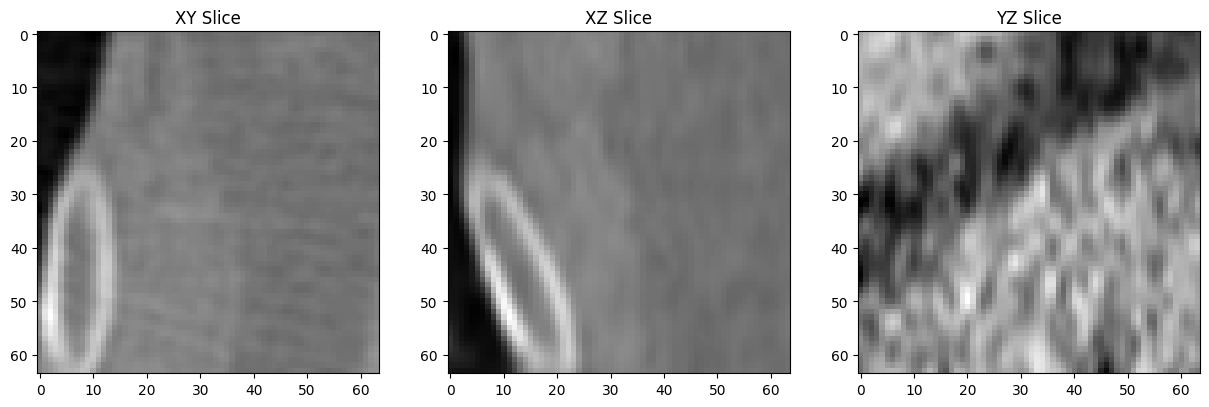

In [ ]:
annotations = pd.read_csv('/content/drive/MyDrive/Lung_Nodule_Analysis/annotations.csv')

name = "1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565"

indices = annotations[annotations['seriesuid'] == name].index


print(indices)

offset = OUTPUT_DIM//2

for i in indices:

        #get row data and nodule voxel coords
        row = annotations.iloc[i]
        print(row)
        world_coords = np.array([row.coordX, row.coordY, row.coordZ])
        # add offset to voxel coords to cope with padding
        coords = np.floor(world_2_voxel(world_coords,origin,new_spacing)).astype(int) + offset
        # label = row.label

        # Create xy, xz, yz
        xy_slice = np.transpose(image[coords[0]-offset:coords[0]+offset,coords[1]-offset:coords[1]+offset,coords[2]])
        xz_slice = np.rot90(image[coords[0]-offset:coords[0]+offset,coords[1],coords[2]-offset:coords[2]+offset])
        yz_slice = np.rot90(image[coords[0],coords[1]-offset:coords[1]+offset,coords[2]-offset:coords[2]+offset])

        test_coords = world_2_voxel(world_coords,origin,spacing)
        print('x:',test_coords[0],'y:',test_coords[1],'z:',test_coords[2])
        plt.figure(figsize=(15, 5))  # Set the figure size to make sure subplots don't overlap

        plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
        plt.imshow(xy_slice, cmap='gray')
        plt.title('XY Slice')

        plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
        plt.imshow(xz_slice, cmap='gray')
        plt.title('XZ Slice')

        plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
        plt.imshow(yz_slice, cmap='gray')
        plt.title('YZ Slice')


        plt.show()